In [1]:
import matplotlib.pyplot as plt
import numpy as np
import requests
import xarray as xr
from matplotlib.colors import LogNorm
from matplotlib.pyplot import fill_between
from scipy.signal import stft
import zarr
from statsmodels.sandbox.distributions.try_pot import mean_residual_life

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from statsmodels.tsa.arima_process import ArmaProcess, arma_acovf, arma_acf, arma_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acovf, acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

import pmdarima as pm

In [3]:
import scienceplots
plt.style.use('science')
plt.rcParams.update({
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage[T1]{fontenc} \usepackage{polski} \usepackage[utf8]{inputenc}'
})
figsize = (6, 3)
linewidth = 0.5
linewidth_time_series = 0.3

In [4]:
shot_data = requests.get("https://mastapp.site/json/shots/30421").json()
endpoint, url = shot_data["endpoint_url"], shot_data["url"]
shot_url = url.replace("s3:/", endpoint)

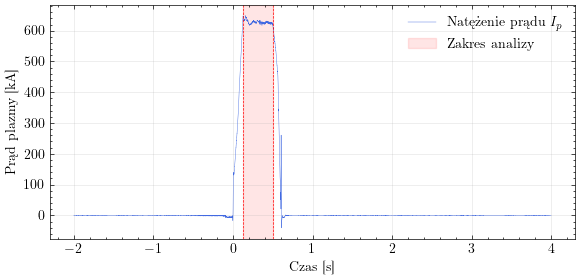

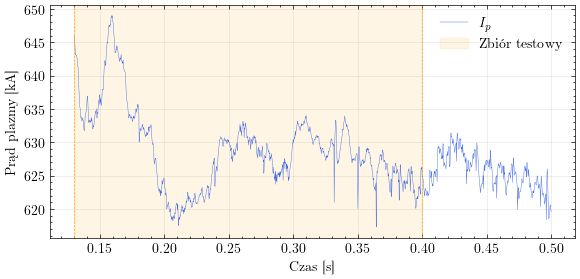

In [5]:
dataset = xr.open_zarr(shot_url, group='amc', storage_options={'ssl': False})
# dataset = dataset.isel(time=(dataset.time > 0) & (dataset.time < .35))
dataset = dataset.isel()
ts_full = dataset['plasma_current'].to_series()

start_cut = 0.13
end_cut = 0.5
test_end_cut = 0.4
mast_data_full = ts_full[(ts_full.index > start_cut) & (ts_full.index < end_cut)]
mast_data = ts_full[(ts_full.index > start_cut) & (ts_full.index < test_end_cut)]

# RYSUNEK 1: Cały przebieg z zaznaczonym wycinkiem
plt.figure(figsize=figsize)
plt.plot(dataset['time'], dataset['plasma_current'], label='Natężenie prądu $I_p$', color='royalblue', linewidth=linewidth_time_series)

plt.axvline(x=start_cut, color='red', linestyle='--', linewidth=linewidth)
plt.axvline(x=end_cut, color='red', linestyle='--', linewidth=linewidth)
plt.axvspan(start_cut, end_cut, color='red', alpha=0.1, label='Zakres analizy')

plt.xlabel("Czas [s]")
plt.ylabel("Prąd plazmy [kA]")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("latex/figures/figure1.pdf")
plt.show()

# RYSUNEK 2: Tylko ten wycinek ze zbiorem testowym (mast_data)
plt.figure(figsize=figsize)
plt.plot(mast_data_full, color='royalblue', linewidth=linewidth_time_series, label='$I_p$')

plt.axvline(x=start_cut, color='orange', linestyle='--', linewidth=linewidth)
plt.axvline(x=test_end_cut, color='orange', linestyle='--', linewidth=linewidth)
plt.axvspan(start_cut, test_end_cut, color='orange', alpha=0.1, label='Zbiór testowy')

plt.xlabel("Czas [s]")
plt.ylabel("Prąd plazmy [kA]")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("latex/figures/figure2.pdf")
plt.show()


---
# ACF, PACF
---

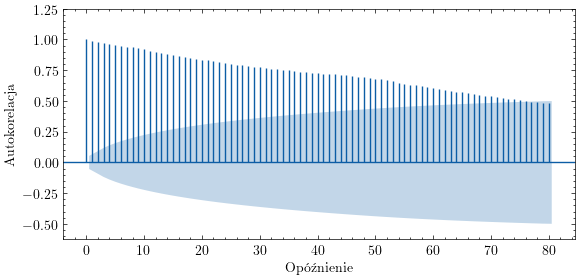

In [6]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)

plot_acf(mast_data, lags=80, ax=ax, marker="", auto_ylims=True)
ax.set_xlabel('Opóźnienie')
ax.set_ylabel('Autokorelacja')
ax.set_title('')

plt.tight_layout()
plt.savefig("latex/figures/empiryczna_acf_surowe.pdf")


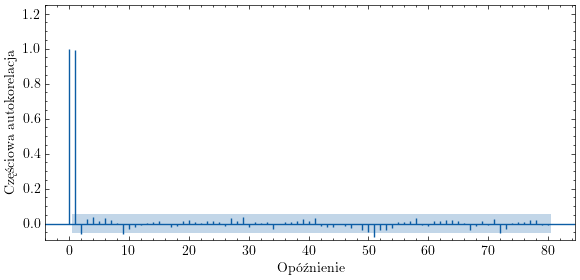

In [7]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)

plot_pacf(mast_data, lags=80, ax=ax, marker="", auto_ylims=True)
ax.set_xlabel('Opóźnienie')
ax.set_ylabel('Częściowa autokorelacja')
ax.set_title('')

plt.tight_layout()
plt.savefig("latex/figures/empiryczna_pacf_surowe.pdf")


---
# test ADF
---

In [8]:
def adfuller_test(series, sig = 0.05):
    res = adfuller(series, autolag='AIC')
    p_value = round(res[1], 3)
    stats   = round(res[0], 3)

    if p_value <= sig:
        print(f"Statystyka testowa = {stats}, p-Value = {p_value} => Stationary. ")
    else:
        print(f"Statystyka testowa = {stats}, p-value = {p_value} => Non-stationary.")

adfuller_test(mast_data)

Statystyka testowa = -2.625, p-value = 0.088 => Non-stationary.


---
# dekompozycja
---

### Dekompozycja szeregu czasowego - przykład 2

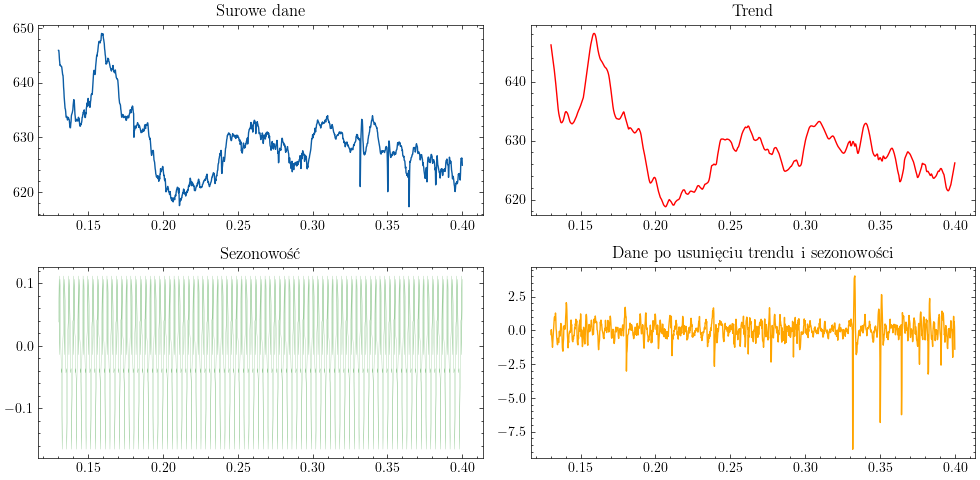

In [9]:
period = 16

decomposition = seasonal_decompose(mast_data, model='additive', period=period, extrapolate_trend=1)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.plot(mast_data, label='Original')
plt.title('Surowe dane')

plt.subplot(2, 2, 2)
plt.plot(trend, label='Trend', color='red')
plt.title('Trend')

plt.subplot(2, 2, 3)
plt.plot(seasonal, label='Seasonal', color='green', linewidth=0.1)
plt.title('Sezonowość')

plt.subplot(2, 2, 4)
plt.plot(residual, label='Residual', color='orange')
plt.title('Dane po usunięciu trendu i sezonowości')

plt.tight_layout()
plt.show()

In [10]:
### Dekompozycja szeregu czasowego - przykład 3

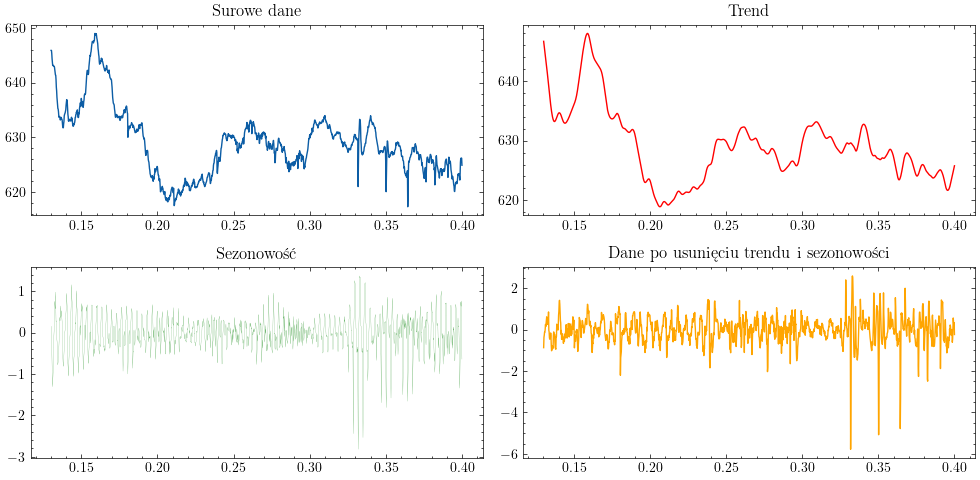

In [11]:
# https://otexts.com/fpp2/stl.html

stl_decomposition = STL(mast_data, period=period).fit()

trend_stl = stl_decomposition.trend
seasonal_stl = stl_decomposition.seasonal
residual_stl = stl_decomposition.resid

plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.plot(mast_data, label='Original')
plt.title('Surowe dane')

plt.subplot(2, 2, 2)
plt.plot(trend_stl, label='Trend', color='red')
plt.title('Trend')

plt.subplot(2, 2, 3)
plt.plot(seasonal_stl, label='Seasonal', color='green', linewidth=0.1)
plt.title('Sezonowość')

plt.subplot(2, 2, 4)
plt.plot(residual_stl, label='Residual', color='orange')
plt.title('Dane po usunięciu trendu i sezonowości')

plt.tight_layout()
plt.show()

### Dekompozycja szeregu czasowego - przykład 4

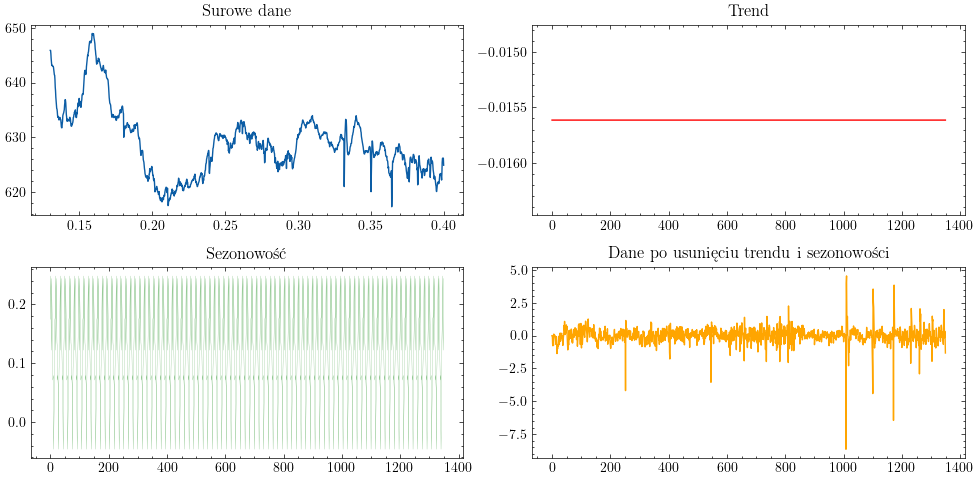

In [12]:
# https://otexts.com/fpp2/holt-winters.html

ets_model = ExponentialSmoothing(mast_data.values, seasonal_periods=period, trend='add', seasonal='add').fit()

trend_ets = ets_model.trend
seasonal_ets = ets_model.season
residual_ets = ets_model.resid

plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.plot(mast_data, label='Original')
plt.title('Surowe dane')

plt.subplot(2, 2, 2)
plt.plot(trend_ets, label='Trend', color='red')
plt.title('Trend')

plt.subplot(2, 2, 3)
plt.plot(seasonal_ets, label='Seasonal', color='green', linewidth=0.1)
plt.title('Sezonowość')

plt.subplot(2, 2, 4)
plt.plot(residual_ets, label='Residual', color='orange')
plt.title('Dane po usunięciu trendu i sezonowości')

plt.tight_layout()
plt.show()

### dekompozycja - empirical mode decomposition

5000.0


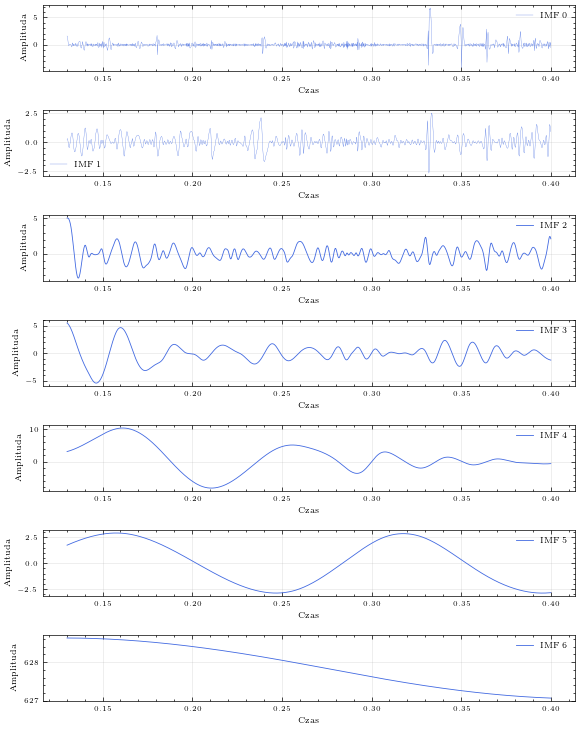

In [13]:
# empirical mode decomposition??
import emd

t = mast_data.index
imf = emd.sift.sift(mast_data.values)
sample_rate = (len(imf)/(test_end_cut - start_cut))
print(sample_rate)

IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'hilbert')

# Define frequency range (low_freq, high_freq, nsteps, spacing)
freq_range = (0.1, 10, 80, 'log')
f, hht = emd.spectra.hilberthuang(IF, IA, freq_range, sum_time=False)

plt.figure(figsize=(6, 7.5))
for i in range(imf.shape[1]):
    if i < 2:
        linewidthh = 0.2
    else:
        linewidthh = 0.6
    plt.subplot(imf.shape[1], 1, i + 1)
    plt.plot(t, imf[:, i], color='royalblue', linewidth=linewidthh, label=f"IMF {i}")
    plt.ylabel(f"Amplituda", fontsize=6)
    plt.xlabel("Czas", fontsize=6)
    plt.yticks(fontsize=5)
    plt.xticks(fontsize=5)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=6)
plt.tight_layout()
plt.savefig('mast_data_decomposition.pdf')


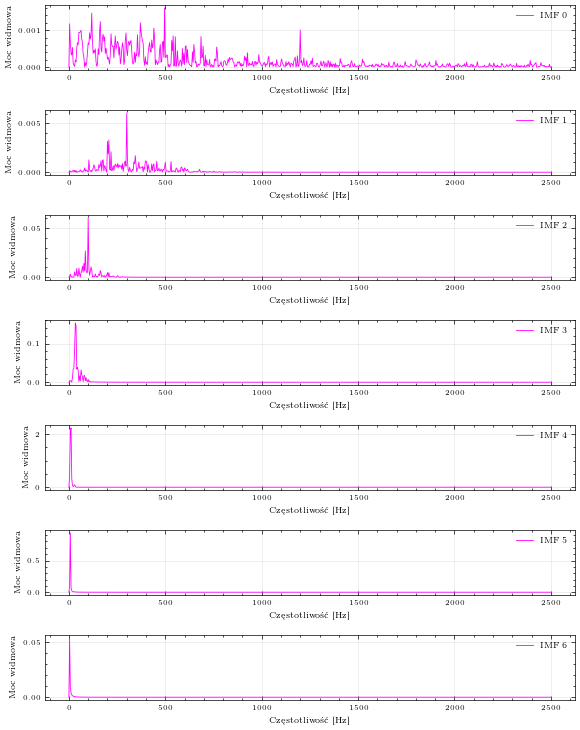

In [14]:
from scipy.signal import periodogram

fs = sample_rate

plt.figure(figsize=(6, 7.5))
for i in range(imf.shape[1]):
    f, Pxx = periodogram(imf[:, i], fs=sample_rate)
    plt.subplot(imf.shape[1], 1, i + 1)
    plt.plot(f, Pxx, color='magenta', label=f"IMF {i}", linewidth=0.6)

    plt.xlabel("Częstotliwość [Hz]", fontsize=6)
    plt.ylabel("Moc widmowa", fontsize=6)
    plt.yticks(fontsize=5)
    plt.xticks(fontsize=5)
    plt.legend(fontsize=6)
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('mast_data_decomposition_periodograms.pdf')

---
# wykresy acf, pacf dla uzyskanego szeregu
---

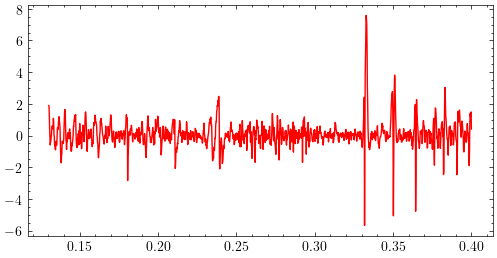

In [15]:
ts_analysis = imf[:, 0] + imf[:, 1]

plt.figure(figsize=figsize)
plt.plot(t, ts_analysis, label='Trend', color='red')


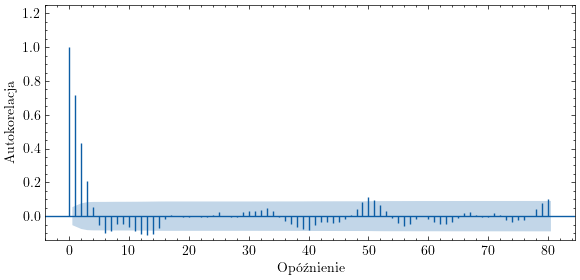

In [16]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)

plot_acf(ts_analysis, lags=80, ax=ax, marker="", auto_ylims=True)
ax.set_xlabel('Opóźnienie')
ax.set_ylabel('Autokorelacja')
ax.set_title('')

plt.tight_layout()
plt.savefig("latex/figures/empiryczna_acf_po_dekompozycji.pdf")


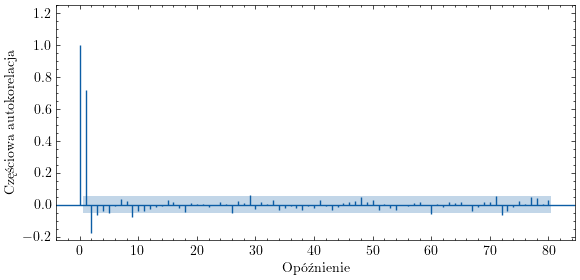

In [17]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)

plot_pacf(ts_analysis, lags=80, ax=ax, marker="", auto_ylims=True)
ax.set_xlabel('Opóźnienie')
ax.set_ylabel('Częściowa autokorelacja')
ax.set_title('')

plt.tight_layout()
plt.savefig("latex/figures/empiryczna_pacf_po_dekompozycji.pdf")


---
# test ADF
---

In [18]:
adfuller_test(ts_analysis)

Statystyka testowa = -11.654, p-Value = 0.0 => Stationary. 


---
# modelowanie ARMA
---

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3355.725, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2625.367, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2396.080, Time=0.03 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=2337.163, Time=0.03 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=2320.782, Time=0.05 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=2312.577, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2354.200, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2321.494, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2315.567, Time=0.04 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=2316.353, Time=0.06 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=2315.640, Time=0.08 sec
 ARIMA(1,0,5)(0,0,0)[0]             : AIC=2314.207, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2314.349, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2307.383, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2308.793, Time=0.08 sec
 ARIMA(2,0

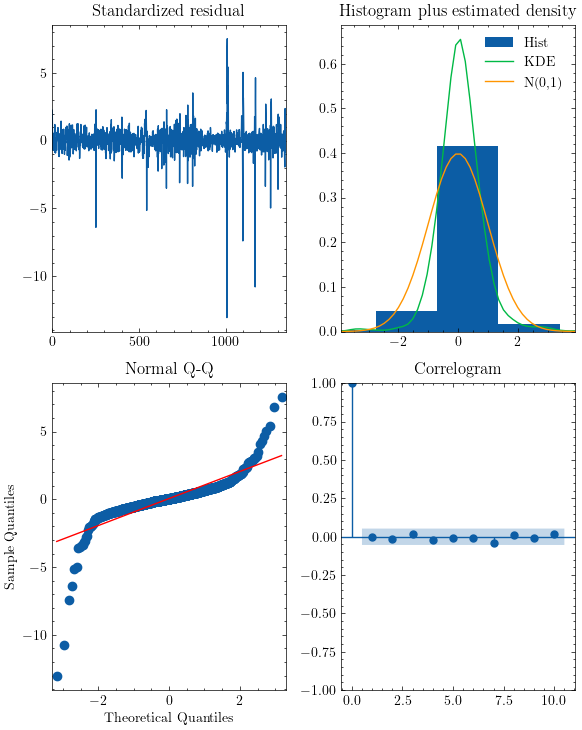

In [19]:
model = pm.auto_arima(ts_analysis,
                       d=0,
                       start_p=0,
                       start_q=0,
                       max_d=0,
                       max_p=5,
                       max_q=5,
                       max_order=None,
                       trace=True,
                       seasonal=False,
                       stepwise = False)

print(model.summary())

model.plot_diagnostics(figsize=(6, 7.5))
plt.tight_layout()
plt.show()